# Исследование пользователей приложения "Ненужные вещи"

Цель исследования:
- узнать, какой пользовательский сегмент лучше других по Retention Rate
- узнать, какой пользовательский сегмент лучше других по конверсии
- узнать, различается ли конверсия в целевое действие у пользователей, пришедших из yandex и google
- узнать, различается ли частота захода в приложение в будние и выходные дни

Перечень задач, необходимых для достижения целей:

1. Выгрузка датасетов
 - Выгрузка mobile_sources
 - Выгрузка mobile_dataset
2. Предобработка данных
 - Привести названия столбцов обоих датасетов к формату слово1_слово2 вместо слово1.слово2 и слово1Слово2
 - Удалить миллисекунды в mobile_dataset['event_time'] 
 - Проверить датасеты на наличие пропусков. В случае пропусков ликвидировать всю строку
 - Проверить mobile_sources на наличие дубликатов в userId. При наличии дубликатов удалять их все
 - Объединить события contacts_show и show_contacts в одно - contacts_show
 - Объединить события search_1,search_2 и т.д. в одно - search
 - Привести mobile_dataset['event_time'] к типу datetime
3. Исследовательский анализ данных
 - Исследуем пользователей по Retention Rate
     - Делим пользователей на когорты по числу представленных дней в датасете 
     - Формируем сводную таблицу: столбцы - даты, строки - когорты. В ячейках будет Retention когорты в этот день
     - Строим хитмап по таблице 
     - Делаем выводы: какой характер носит Retention пользователей с течением времени
 - Исследуем пользователей по времени в приложении
     - Делаем сводную таблицу: группируем датасет логов по пользователям и выводим для каждого первую дату захода в приложение ({'event_time':'min'})
     - При помощи apply пишем функцию для добавления в эту таблицу столбца с количеством дней в приложении для каждого пользователя: она будет из максимальной даты в датасете вычитать день первого захода
     - Cтроим столбчатую диаграмму по этой таблице, используя столбцы с user_id и количеством дней в приложении
     - Делаем выводы: сколько каких пользователей (по количеству дней в приложении) представлено в наших датасетах
 - Исследуем пользователей по частоте захода (принимаем сессию за один день)
     - Создаём длинную вертикальную сводную таблицу: группируем датасет логов по пользователю и выводим количество уникальных дней, в которые были действия, им совершённые. Такая таблица показывает, сколько дней пользователь проявлял активность в приложении
     - Делаем правый JOIN (чтобы не потерять пользователей, зарегистрировавшихся, но не сделавших до сих пор ни одного действия, если такие вдруг имеются) с конечной таблицей из прошлого пункта (оставляя от неё только столбцы пользователь и количество его дней в приложении)
     - Создаём третий столбец: делим столбец с количеством активных дней на столбец с общим количеством дней этого пользователя и умножаем на 100, получая долю в % активных дней от всех. При этом округялем до целого %, для удобства дальнейшей группировки
     - Визуализируем последнюю таблицу, которую дополнительно группируем по % частоты захода. Агрегированные данные в этом случае: количество людей с таким % частоты
 - Исследуем пользователей на конверсию в целевое действие:
     - Находим отношение количества уникальных пользователей в таблице mobile_dataset, где действие - tips show к общему количеству уникальных пользователей mobile_dataset 
4. Сегментация пользователей
 - Провожу сегментацию по частоте заходов, определяя группу для пользователя по вхождению его частоты захода в один из квартилей массива частот захода всех пользователей 
 - Даю ответ на вопрос, какая группа лучше по Retention
 - Даю ответ на вопрос, какая группа лучше по конверсии
5. Проверка гипотез
 - На предмет различия конверсии в просмотры контактов между пользователями, скачавшими приложение из google и из yandex
 - На предмет частоты захода в приложение в выходные и будние дни

# Выгрузка датасетов

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from scipy import stats as st
pd.options.display.max_rows=1000
pd.options.display.max_columns=1000
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [2]:
mobile_sources.head(10)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex
7,57321726-5d66-4d51-84f4-c797c35dcf2b,google
8,c2cf55c0-95f7-4269-896c-931d14deaab5,google
9,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex


In [3]:
mobile_dataset.head(10)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


Структура предельно понятна

# Предобработка данных

## Привести названия столбцов обоих датасетов к формату слово1_слово2 вместо слово1.слово2 и слово1Слово2

In [4]:
mobile_sources=mobile_sources.rename(columns={'userId':'user_id'})
mobile_dataset=mobile_dataset.rename(columns={'event.time':'event_time','event.name':'event_name','user.id':'user_id'})

## Удалить миллисекунды в mobile_dataset['event_time']

In [5]:
new_event_time=[]
for i in mobile_dataset['event_time']:
    new_event_time.append(i[:-7])
mobile_dataset['event_time']=new_event_time
mobile_dataset

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


In [6]:
mobile_dataset_original=mobile_dataset.copy()

## Проверить датасеты на наличие пропусков. В случае пропусков ликвидировать всю строку

In [7]:
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [8]:
mobile_sources.isna().sum()

user_id    0
source     0
dtype: int64

Пропусков нет, идём дальше

## Проверить mobile_sources на наличие дубликатов в userId. При наличии дубликатов удалять их все

In [9]:
mobile_sources['user_id'].duplicated().sum()

0

Всё в норме

## Объединить события contacts_show и show_contacts в одно - contacts_show

In [10]:
mobile_dataset['event_name']=mobile_dataset['event_name'].fillna({'show_contacts':'contacts_show'})

In [11]:
mobile_dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Осталось только contacts_show, всё по плану

## Объединить события search_1,search_2 и т.д. в одно - search

In [12]:
mobile_dataset['event_name']=mobile_dataset['event_name'].replace({'search_1':'search','search_2':'search','search_3':'search',
                                      'search_4':'search','search_5':'search','search_6':'search',
                                      'search_7':'search'})

In [13]:
mobile_dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4450
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
show_contacts       79
Name: event_name, dtype: int64

Остался один search, всё в норме

## Привести mobile_dataset['event_time'] к типу datetime

In [14]:
mobile_dataset['event_time']=pd.to_datetime(mobile_dataset['event_time'])
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


Привёл

# Исследовательский анализ данных

## Исследуем пользователей по Retention Rate

### Делим пользователей на когорты по числу представленных дней в датасете

In [15]:
mobile_dataset['event_time']=mobile_dataset['event_time'].astype('str')
user_start=mobile_dataset
# привожу к типу string, т.к. от строк удобнее отсекать время, оставляя только дату через индексацию

In [16]:
new_event_time=[]
for i in mobile_dataset['event_time']:
    new_event_time.append(i[:-9])
user_start['event_time']=new_event_time
mobile_dataset['event_time']=pd.to_datetime(mobile_dataset['event_time'])

In [17]:
user_start=user_start.groupby('user_id',as_index=False).agg({'event_time':'min'})

In [18]:
user_start['event_time']=pd.to_datetime(user_start['event_time'],format="%Y-%m-%d")

Итого имеем таблицу user_start: пользователь + день первого захода

### Формируем сводную таблицу: столбцы - даты, строки - когорты. В ячейках будет Retention когорты в этот день

In [19]:
# Столбец с размерами когорот
cohort_size=user_start.groupby('event_time',as_index=False).agg({'user_id':'count'}).rename(columns={'user_id':'all',
                                                                         'event_time':'cohort_start'})
cohort_size['cohort_start'] = pd.to_datetime(cohort_size['cohort_start']).dt.date

#следующий кусок кода создаёт список списков, где списки - ретеншен каждой когорты. Сам список списков (l) будет использоваться 
# далее для формирования dataframe'а 
l=[]
for j in cohort_size['cohort_start']:
    p=[]
    for i in cohort_size['cohort_start']:
        p.append(mobile_dataset[(mobile_dataset['event_time'].dt.date==i)&
                (mobile_dataset['user_id'].isin(user_start[user_start['event_time'].dt.date==j]['user_id']))]
                 ['user_id'].nunique()*100)
    l.append(p)

pivot_table=pd.DataFrame(data=l,columns=cohort_size['cohort_start'].unique())
# +добавляем столбик с размерами когорт
pivot_table=pd.concat([cohort_size,pivot_table],axis=1).set_index('cohort_start',drop=True)
#делим все столбики на исходные размеры когорты и получаем ретеншен в ячейках, вместо числа людей
pivot_table=pivot_table.div(pivot_table['all'],axis=0).drop(columns='all')
#чтобы хоть как-то визуально отличать ретеншен день ото дня я зануляю первый день в каждой когорте
pivot_table=pivot_table.replace({100:0})

### Строим хитмап по таблице

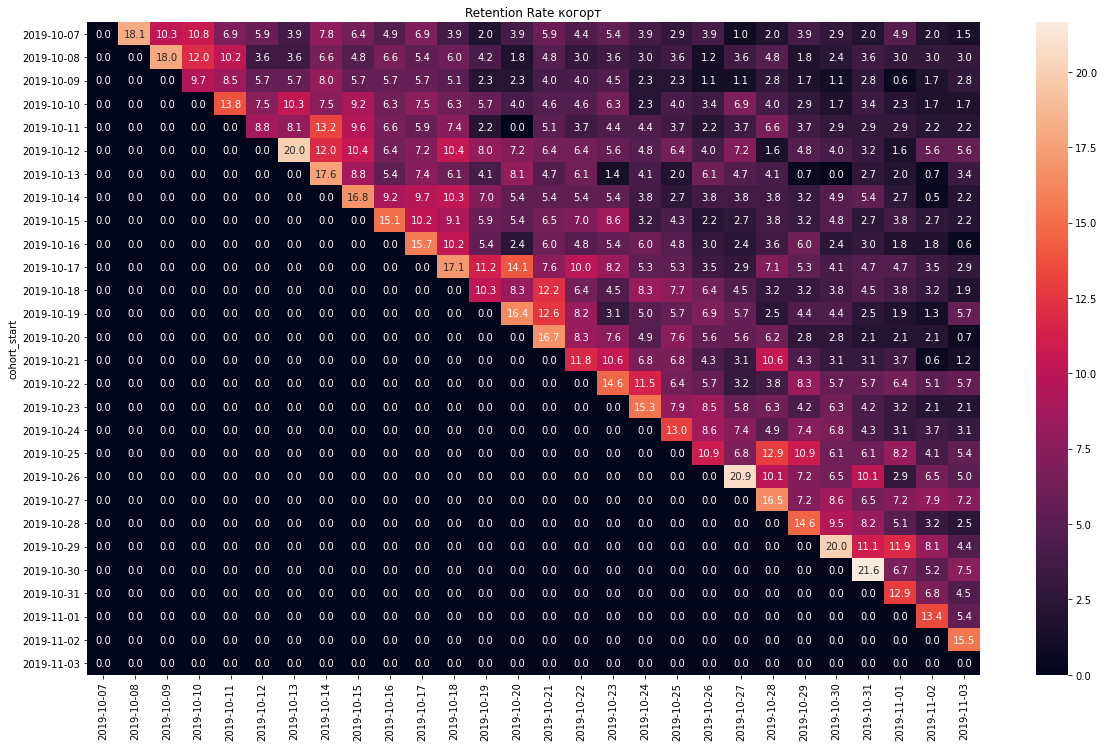

In [20]:
plt.figure(figsize=(20,12))
plt.title('Retention Rate когорт')
plt.ylabel('Когорта')
plt.xlabel('День')
sns.heatmap(pivot_table,annot=True,fmt=".1f");

### Делаем выводы: какой характер носит Retention пользователей с течением времени

Как видно, Retention убывает очень быстро: в большинстве случаев уже на второй день использования заходит только 1 из 6-7 человек. А через неделю остаётся порядка 6-7-8% людей. Далее retention  заходит в диапазон 0-5%, за рамки которого он почти не выходит

## Исследуем пользователей по времени в приложении

### Делаем сводную таблицу: группируем датасет логов по пользователям и выводим для каждого первую дату захода в приложение ({'event_time':'min'})

In [21]:
first_visit=user_start.rename(columns={'event_time':'first_visit'})

In [22]:
first_visit

,user_id,first_visit
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21


### При помощи apply пишем функцию для добавления в эту таблицу столбца с количеством дней в приложении для каждого пользователя: она будет из максимальной даты в датасете вычитать день первого захода

In [23]:
mx=max(first_visit['first_visit'])
def func (a):
    return mx-a[1]+timedelta(1)

first_visit['days']=first_visit.apply(func,axis=1)

### Cтроим столбчатую диаграмму по этой таблице, используя столбцы с user_id и количеством дней в приложении

In [24]:
# для каждого из количества дней выводим количество уникальных пользователей, зарегистрировавшихся в этот день
first_visit_9_3=first_visit.groupby('days',as_index=False).agg({'user_id':'nunique'}).sort_values(by='days',ascending=False)
first_visit_9_3['days']=first_visit_9_3['days'].astype('str')

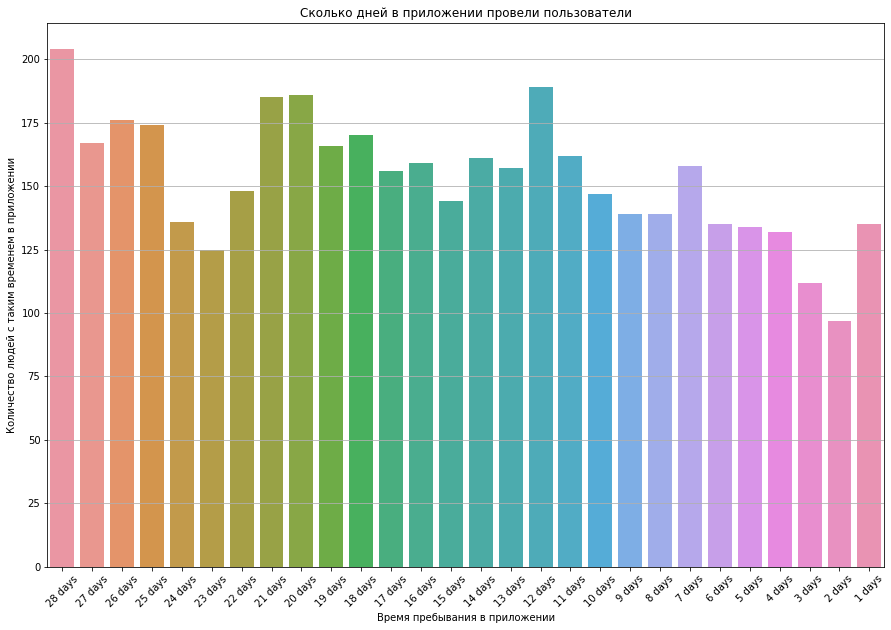

In [25]:
plt.figure(figsize=(15,10))
plt.title('Сколько дней в приложении провели пользователи')
plt.grid()
plt.xticks(rotation=45)
ax = sns.barplot(x='Время пребывания в приложении',y='Количество людей с таким временем в приложении',data=
                                           first_visit_9_3.rename(columns={'days':'Время пребывания в приложении'
                                                                          ,'user_id':'Количество людей с таким временем в приложении'}))

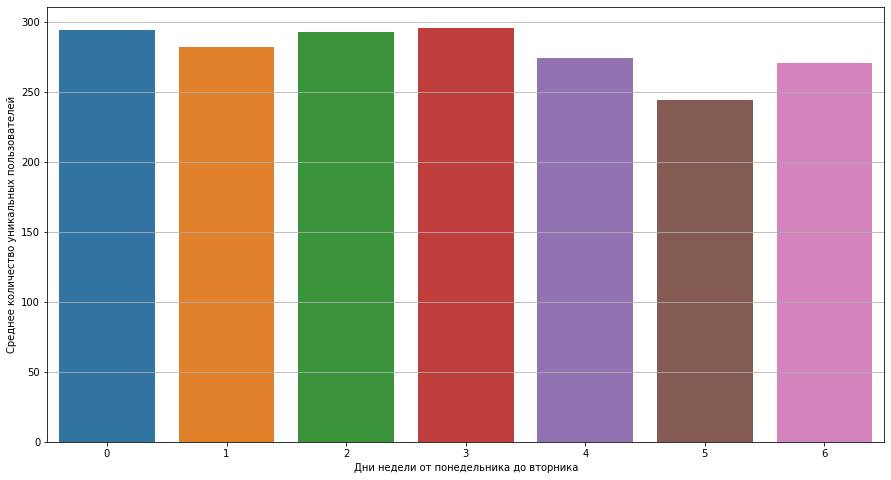

In [26]:
mobile_dataset['day']=mobile_dataset['event_time'].dt.weekday
table_9=mobile_dataset.groupby('event_time',as_index=False).agg({'user_id':'nunique','day':'mean'})

plt.figure(figsize=(15,8))
plt.grid()
ax = sns.barplot(data=table_9.groupby('day',as_index=False).agg({'user_id':'mean'}).rename(columns={
    'day':'Дни недели от понедельника до вторника','user_id':'Среднее количество уникальных пользователей'}),x='Дни недели от понедельника до вторника',y='Среднее количество уникальных пользователей')

### Делаем выводы: сколько каких пользователей (по количеству дней в приложении) представлено в наших датасетах

Как видно, количество пользователей, зарегистрировавшихся в приложении 10 - 27 дней назад не имеет явной тенденции. Однако далее с течением дня в календаре количество пользователей, начавших пользоваться приложением, всё меньше  

Как оказалось, в выходные дни в приложении находится меньше всего пользователей

## Исследуем пользователей по частоте захода (принимаем сессию за один день)

### Создаём длинную вертикальную сводную таблицу: группируем датасет логов по пользователю и выводим количество уникальных дней, в которые были действия, им совершённые. Такая таблица показывает, сколько дней пользователь проявлял активность в приложении

In [27]:
table_10_1=mobile_dataset.groupby('user_id',as_index=False).agg({'event_time':'nunique'})
table_10_1=table_10_1.rename(columns={'event_time':'active_days'})
table_10_1

,user_id,active_days
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,6
2,00463033-5717-4bf1-91b4-09183923b9df,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6
4,00551e79-152e-4441-9cf7-565d7eb04090,3
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,1
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,3


### Делаем левый JOIN с конечной таблицей из прошлого пункта (оставляя от неё только столбцы пользователь и количество его дней в приложении)

In [28]:
table_10_1=table_10_1.merge(first_visit[['user_id','days']],left_on='user_id',right_on='user_id',how='left')
table_10_1=table_10_1.rename(columns={'days_x':'all_days','event_time':'active_days'})
table_10_1

,user_id,active_days,days
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,28 days
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,16 days
2,00463033-5717-4bf1-91b4-09183923b9df,1,3 days
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,17 days
4,00551e79-152e-4441-9cf7-565d7eb04090,3,10 days
...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2,22 days
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1,28 days
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,12 days
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,3,14 days


Итого имеем таблицу, где у каждого пользователя есть количество дней, прошедших с дня его первого захода в приложение и количество активных дней 

### Создаём третий столбец: делим столбец с количеством активных дней на столбец с общим количеством дней этого пользователя и умножаем на 100, получая долю в % активных дней от всех. При этом округялем до целого %, для удобства дальнейшей группировки


In [29]:
#Создаём список списков и потом перезаписываем c его помощью table_10_1['days']
l=[]
for i in table_10_1['days']:
    k=''
    for j in str(i):
        if j!=' ':
            k+=j
        else:
            break
    l.append(k)
table_10_1['days']=l
table_10_1['days']=table_10_1['days'].astype('int')

table_10_1['percent']=table_10_1['active_days']*100/table_10_1['days']
table_10_1['percent']=table_10_1['percent'].apply(np.ceil)

In [30]:
people_percent=table_10_1

In [31]:
table_10_1

,user_id,active_days,days,percent
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,28,15.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,16,38.0
2,00463033-5717-4bf1-91b4-09183923b9df,1,3,34.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,17,36.0
4,00551e79-152e-4441-9cf7-565d7eb04090,3,10,30.0
...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2,22,10.0
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1,28,4.0
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,12,9.0
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,3,14,22.0


Получили вдобавок к каждому пользователю процент его активных дней

### Визуализируем последнюю таблицу, которую дополнительно группируем по % частоты захода. Агрегированные данные в этом случае: количество людей с таким % частоты

In [32]:
table_10_1=table_10_1.groupby('percent',as_index=False).agg({'days':'count'})
table_10_1

,percent,days
0,4.0,400
1,5.0,447
2,6.0,292
3,7.0,188
4,8.0,349
5,9.0,169
6,10.0,309
7,11.0,61
8,12.0,191
9,13.0,139


Как видим, есть порядка 240 человек с неадекватной частотой захода: от 100% и более. Но 240 на фоне общего числа цифра не большая, можно их отбросить:

In [33]:
table_10_1=table_10_1[table_10_1['percent']<=100]

In [34]:
table_10_1['percent']=table_10_1['percent'].astype('int')

In [35]:
table_10_1

,percent,days
0,4,400
1,5,447
2,6,292
3,7,188
4,8,349
5,9,169
6,10,309
7,11,61
8,12,191
9,13,139


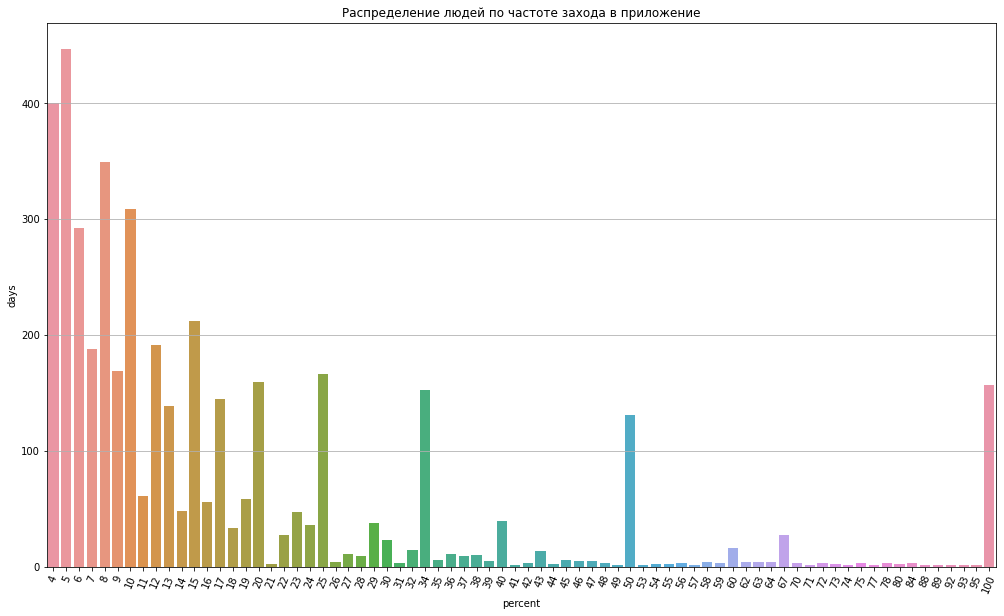

In [36]:
plt.figure(figsize=(17,10))
plt.grid()
plt.xticks(rotation=67)
plt.title('Распределение людей по частоте захода в приложение')
plt.xlabel('Процент частоты захода')
plt.ylabel('Количество людей с таким процентом')
ax = sns.barplot(x='percent',y='days',data=table_10_1)

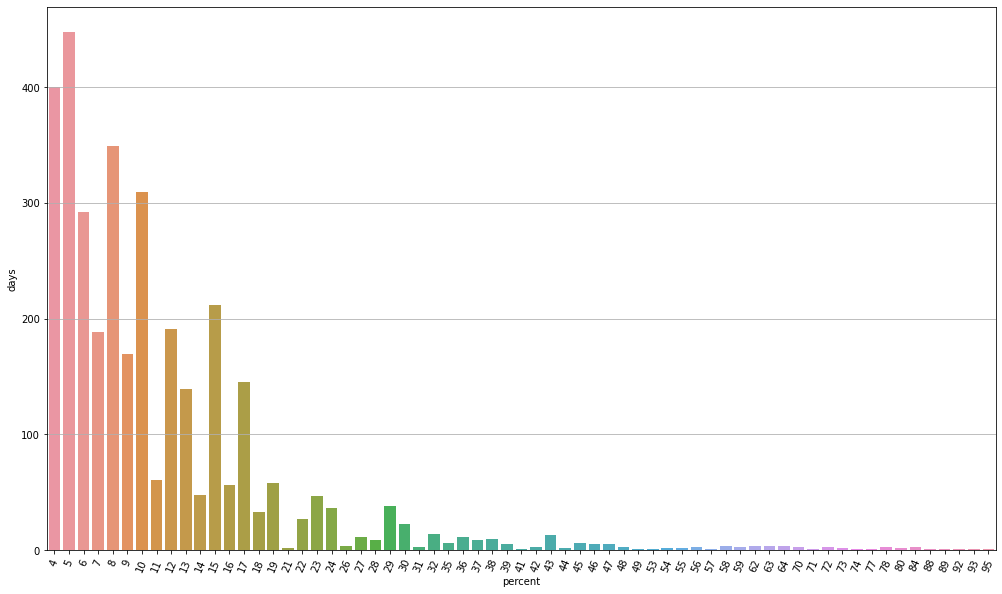

In [37]:
# без выбросов
plt.figure(figsize=(17,10))
plt.grid()
plt.xticks(rotation=67)
ax = sns.barplot(x='percent',y='days',data=table_10_1[~table_10_1['percent'].isin([100,75,67,60,50,40,34,25,20])])

Как видим, имеются выбросы, обусловленные тем, что есть не мало людей, которые в приложении 1-2-3-4-5-6 дней и у их частоты захода не много вариантов: быть 17-20-25-34-50-67-75-80 или 100 процентов.

Среди же пользователей, давно пользующихся приложением (в разной степени), виднеется нисходящее распределение

In [38]:
table_new=mobile_dataset.groupby('user_id',as_index=False).agg({'event_time':'nunique'})
table_new=table_new.rename(columns={'event_time':'active_days'})

In [39]:
table_new=table_new.rename(columns={'active_days':'Продолжительность сессий','user_id':'количество людей'})

In [40]:
table_new

,количество людей,Продолжительность сессий
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,6
2,00463033-5717-4bf1-91b4-09183923b9df,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6
4,00551e79-152e-4441-9cf7-565d7eb04090,3
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,1
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,3


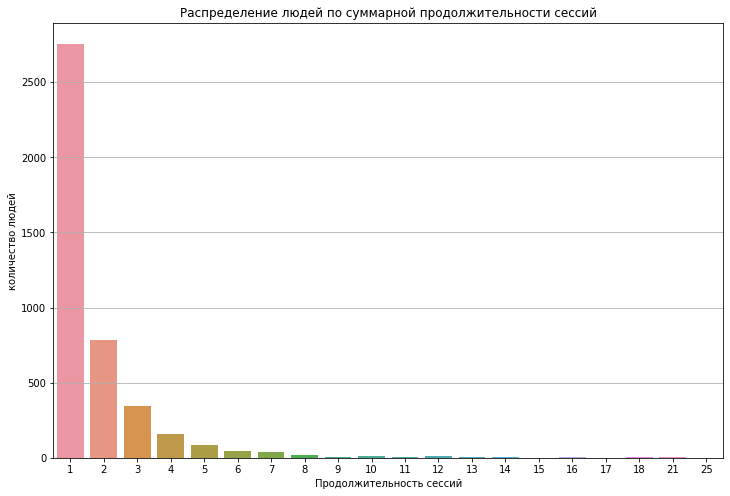

In [41]:
plt.figure(figsize=(12,8))
plt.grid(True)
plt.title('Распределение людей по суммарной продолжительности сессий')
ax = sns.barplot(data=table_new.groupby('Продолжительность сессий',as_index=False).agg({'количество людей':'count'}
                                                ),x='Продолжительность сессий',y='количество людей')

In [42]:
table_new.quantile(0.95)

Продолжительность сессий    5.0
Name: 0.95, dtype: float64

In [43]:
table_new['Продолжительность сессий'].mean()

1.8208711856510598

In [44]:
table_new.groupby('Продолжительность сессий',as_index=False).agg({'количество людей':'count'}
                                                )

,Продолжительность сессий,количество людей
0,1,2756
1,2,786
2,3,346
3,4,161
4,5,86
5,6,45
6,7,39
7,8,20
8,9,8
9,10,11


Как видно по графику, распределение стремительно нисходящие, 95% пользователей в приложении провели не более 5 дней. Средний же пользователь проводит в приложении вообще не более 2 сессий=активных дней. Аномальные продолжительности сессий есть, и формируются из людей, которые одновременно и рано начали пользоваться приложением, и часто в него заходят. Выбросов на общем фоне совсем мало, "хвост" из них очень тонкий

In [45]:
mobile_dataset

,event_time,event_name,user_id,day
0,2019-10-07,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,0
1,2019-10-07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,0
2,2019-10-07,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,0
3,2019-10-07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,0
4,2019-10-07,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,0
...,...,...,...,...
74192,2019-11-03,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,6
74193,2019-11-03,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,6
74194,2019-11-03,search,20850c8f-4135-4059-b13b-198d3ac59902,6
74195,2019-11-03,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,6


### Исследую сессии на продолжительность

In [46]:
new_table=mobile_dataset_original
new_table['event_day']=pd.to_datetime(new_table['event_time'],format='%Y-%m-%d %H:%M:%S')
new_table['event_day']=new_table['event_day'].dt.day
# получаем таблицу из всех сессий: с началом и концом + пользователем 
new_table=new_table.groupby(['user_id','event_day'],as_index=False).agg({'event_time':['min','max']})

new_table[('event_time','max')]=pd.to_datetime(new_table[('event_time','max')],format='%Y-%m-%d %H:%M:%S')
new_table[('event_time','min')]=pd.to_datetime(new_table[('event_time','min')],format='%Y-%m-%d %H:%M:%S')

In [47]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7817 entries, 0 to 7816
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (user_id, )        7817 non-null   object        
 1   (event_day, )      7817 non-null   int64         
 2   (event_time, min)  7817 non-null   datetime64[ns]
 3   (event_time, max)  7817 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 305.4+ KB


In [48]:
new_table['duration']=new_table[('event_time','max')]-new_table[('event_time','min')]

In [49]:
# средняя продолжительность сессии 
new_table['duration'].mean()

Timedelta('0 days 01:23:02.005117052')

In [50]:
# Добавляем столбик с количеством часов, которое продолжалась сессия
l=[]
for i in new_table['duration']:
    l.append(str(i)[7:9])
new_table['hours']=l
new_table['hours']=new_table['hours'].astype('int')

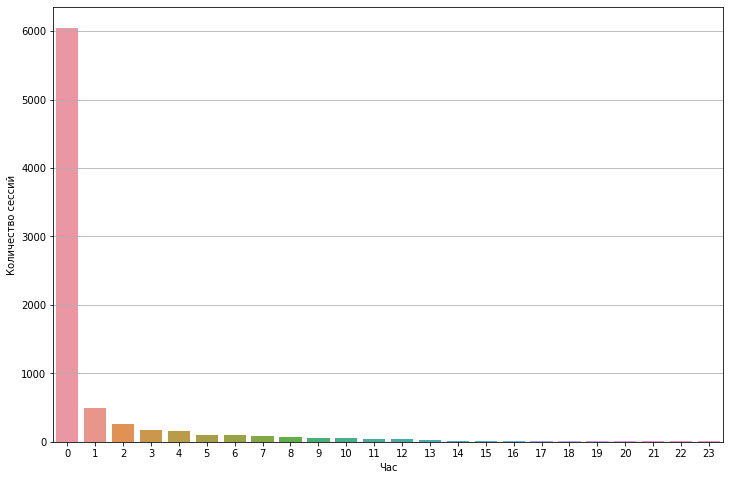

In [51]:
plt.figure(figsize=(12,8))
plt.grid(True)
ax=sns.barplot(data=new_table.groupby(('hours','') ,as_index=False).agg({('user_id',''):'count'}).rename(columns={
    'hours':'Час','user_id':'Количество сессий'}),x='Час',y='Количество сессий')

In [52]:
# таблица для отражения количества сессий по продолжительности в часах и % таких сессий от общего числа сессий
table=new_table.groupby(('hours','') ,as_index=False).agg({('user_id',''):'count'}).rename(columns={
    'hours':'Час','user_id':'Количество сессий'})

In [53]:
sm=table['Количество сессий'].sum()
def func(a):
    return round(a[1]*100/sm,2)

table['percent']=table.apply(func,axis=1)

In [54]:
table

,Час,Количество сессий,percent
,,,
0,0,6050,77.40
1,1,490,6.27
2,2,261,3.34
3,3,172,2.20
4,4,161,2.06
5,5,100,1.28
6,6,104,1.33
7,7,78,1.00
8,8,65,0.83


Как видим, доминирующее число сессий укладываются в рамки часа (77% от общего числа). Аномальные сессии есть, они появляются не из-за непрерывного сеанса, а из повторных заходов в течении дня

In [55]:
new_table[new_table['duration']=='0 days 00:00:00']

user_id event_day          event_time  \
                                                                     min   
4     00157779-810c-4498-9e05-a1e9e3cedf93         3 2019-11-03 17:12:09   
19    00551e79-152e-4441-9cf7-565d7eb04090        29 2019-10-29 02:17:12   
25    00753c79-ea81-4456-acd0-a47a23ca2fb9        20 2019-10-20 14:57:06   
45    0164902d-7393-47e1-9d5b-0ec4c0171cdc        26 2019-10-26 18:50:33   
56    01d283e1-cb1c-407a-a4e0-9f72f3deecca        19 2019-10-19 05:27:22   
...                                    ...       ...                 ...   
7768  fe585541-43a9-4d56-8466-718856a4d195        15 2019-10-15 12:14:56   
7769  fe585541-43a9-4d56-8466-718856a4d195        19 2019-10-19 00:13:20   
7773  fe898476-a038-4717-875d-b01e8cddf537        19 2019-10-19 11:33:31   
7774  fe92fa6c-7eef-484f-b31b-fa0db4e4d895        13 2019-10-13 18:02:11   
7780  fec484eb-838b-4501-ab45-41947b5ce162        22 2019-10-22 14:42:13   

                         duration hours  
                     max                 
4    2019-11-03 17:12:09   0 days     0  
19   2019-10-29 02:17:12   0 days     0  
25   2019-10-20 14:57:06   0 days     0  
45   2019-10-26 18:50:33   0 days     0  
56   2019-10-19 05:27:22   0 days     0  
...                  ...      ...   ...  
7768 2019-10-15 12:14:56   0 days     0  
7769 2019-10-19 00:13:20   0 days     0  
7773 2019-10-19 11:33:31   0 days     0  
7774 2019-10-13 18:02:11   0 days     0  
7780 2019-10-22 14:42:13   0 days     0  

[1014 rows x 6 columns]

Нулевых по продолжительности сессий целых 1014. Так получилось, потому что пользователь за один день сделал всего одно действие

Итоги по исследованию сессий пользователей:
- средняя сессия составляет 01:23:02
- 77% сессий укладывается в рамки одного часа
- аномально большие сессии есть, но их критически мало
- нулевых сессий порядка 13% от общего числа ((1014/6050)*17%)

## Исследуем пользователей на конверсию в целевое действие:

### Находим отношение количества уникальных пользователей в таблице mobile_dataset, где действие - tips show к общему количеству уникальных пользователей mobile_dataset 

In [56]:
round(mobile_dataset[mobile_dataset['event_name']=='contacts_show']['user_id'].nunique()/mobile_dataset['user_id'].nunique(),2)*100

23.0

Итого, 23% пользователей выполнили целевое действие - просмотр контактов продавца

Общий вывод по исследовательскому анализу данных:
- Retention Rate пользователей в большинстве случаев спадает до 15-20% на второй день и до 5% на 7 день, после чего колеблется в пределах от 0 до 6-7% 
- Пользователи чаще всего проводят время в приложении в будние дни. Выходные - на низу списка популярных дней
- Распределение частоты захода пользователей - нисходящее. БОльшая часть пользователей имеет не более 10% активных дней от общего числа дней, прошедших после первого захода
- Просмотр контактов (целевое действие) осуществляет примерно 1 человек из четырёх (23%)

## Сегментация пользователей

### Провожу сегментацию по частоте заходов, определяя группу для пользователя по вхождению его частоты захода в один из квартилей массива частот захода всех пользователей

Сегментацию я буду проводить по частоте захода пользователей в приложение. Такое разделение поможет понять поведение пользователей: какая у них степень склонности заходить каждый день, насколько развита у них привязанность -> можно будет определять диапазон дат, в который можно проводить акции (чтобы большая часть пользователей смогла застать, но при этом не затягивать), узнать уровень важности ввода функций с целью удержания. Также можно будет выявить проблемных пользователей с низкой частотой захода -> можно будет предлагать им спец.возможности в приложении и повышать их активность

Определяем границы квартилей. На их основе будем сегментировать пользователей. Пользователю будет присвоена 1 из 4 категорий, в зависимости от его частоты захода в приложение. Как я ранее узнал, распределение людей по частоте захода нисходящее, а значит более поздние квартили будут охватывать всё больший диапазон частоты захода 

In [57]:
display(people_percent['percent'].quantile(0.25))
display(people_percent['percent'].quantile(0.5))
display(people_percent['percent'].quantile(0.75))

6.0

10.0

20.0

In [58]:
def category(a):
    if a[3]<=people_percent['percent'].quantile(0.25):
        return '0-6'
    if a[3]>people_percent['percent'].quantile(0.25) and a[3]<=people_percent['percent'].quantile(0.5):
        return '7-11'
    if a[3]>people_percent['percent'].quantile(0.5) and a[3]<=people_percent['percent'].quantile(0.75):
        return '12-24'
    else:
        return '25-100'
people_percent['category']=people_percent.apply(category,axis=1)
people_percent_category=people_percent
people_percent_category

,user_id,active_days,days,percent,category
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,28,15.0,12-24
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,16,38.0,25-100
2,00463033-5717-4bf1-91b4-09183923b9df,1,3,34.0,25-100
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,17,36.0,25-100
4,00551e79-152e-4441-9cf7-565d7eb04090,3,10,30.0,25-100
...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2,22,10.0,7-11
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1,28,4.0,0-6
4290,ffcf50d9-293c-4254-8243-4890b030b238,1,12,9.0,7-11
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,3,14,22.0,25-100


In [59]:
people_percent_category['category'].value_counts(normalize=True)

0-6       0.265316
12-24     0.256697
25-100    0.241556
7-11      0.236431
Name: category, dtype: float64

In [60]:
people_percent_category.groupby('category')['user_id'].nunique()

category
0-6       1139
12-24     1102
25-100    1037
7-11      1015
Name: user_id, dtype: int64

Сегментация проведена, у каждого пользователя появилась категория. Размеры когорт подобраны с минимальным разбросом, перетяг группы людей с одинаковым процентом, между сегментами приведёт к большему разбросу размеров сегментов. 

### Даю ответ на вопрос, какая группа лучше по Retention

Т.к. ретеншен - показатель когорты, а по группам люди распределены на основе частоты захода, то не выйдет оценить влияние группы человека на его Retention. Я буду смотреть по общим тенденциям в когортах, сравнивая как меняется её категориальный состав с нарастанием Retention. Лучше по rr будут те группы, число людей которых в когортах удельно растёт с увеличением rr

Я сделаю выборку из 14 когорт, которые +- одинаковы по габаритам. Для этого посмотрим на процентили количества людей в когорте

In [61]:
display(first_visit.groupby('first_visit',as_index=False).agg({'user_id':'nunique'}).quantile(0.25))
first_visit.groupby('first_visit',as_index=False).agg({'user_id':'nunique'}).quantile(0.75)

user_id    135.75
Name: 0.25, dtype: float64

user_id    167.75
Name: 0.75, dtype: float64

Итого наберём 14 когорт, вписывающихся в эти рамки

In [62]:
# получаем таблицу подходящих когорт, вписывающихся в диапазон от 25 до 75 процентиля
new_table=first_visit.groupby('first_visit',as_index=False).agg({'user_id':'nunique'})
new_table=new_table[(new_table['user_id']<168)&(new_table['user_id']>135)]
new_table

,first_visit,user_id
1,2019-10-08,167
4,2019-10-11,136
6,2019-10-13,148
9,2019-10-16,166
11,2019-10-18,156
12,2019-10-19,159
13,2019-10-20,144
14,2019-10-21,161
15,2019-10-22,157
17,2019-10-24,162


Создаём table_12 для расчёта ретеншена когорт

In [63]:
# пусть в table_12 попадут записи из mobile_dataset, в которых пользователь есть среди в одной из тех самых 14 когорт, определённых
# выше. + добавим столбик первого посещения пользователя. Он же = идентификатор когорты 
table_12=mobile_dataset[mobile_dataset['user_id'].isin(first_visit[first_visit['first_visit'].isin(new_table['first_visit'])
                                                                   ]['user_id'])].merge(
         first_visit,how='left',left_on='user_id',right_on='user_id')[['event_time','user_id','first_visit']]

# Пишем функцию для оределения день ретеншена, в разрезе которого будем сравнивать когорты.

def func(a):
    return a[2]+timedelta(days=4)
table_12['retention_day']=table_12.apply(func,axis=1)

# Оставляем от всего датасета table_12 (расширенный mobile_dataset) только события, которые были в 5ый день своей когорты.
# Т.е. день, чей показатель будет фиксироваться для общего сравнения 
table_12=table_12[table_12['retention_day']==table_12['event_time']]
# Добавляем к пользователям их когорту
table_12=table_12.merge(people_percent_category,how='left',left_on='user_id',right_on='user_id')[['user_id','first_visit','category']]

In [64]:
# создаём таблицу с показателями ретеншена по нашим когортам на 5ий день. Проверил правильность по хитмапу, построенному ранее
new_table=table_12.groupby('first_visit',as_index=False).agg({'user_id':'nunique'}).merge(
                                first_visit.groupby('first_visit').agg({'user_id':'nunique'}
                                                                      ),left_on='first_visit',right_on='first_visit')
new_table['Retention_5_day']=round(new_table['user_id_x']*100/new_table['user_id_y'],2)
new_table=new_table[['first_visit','Retention_5_day']]
new_table

,first_visit,Retention_5_day
0,2019-10-08,3.59
1,2019-10-11,9.56
2,2019-10-13,7.43
3,2019-10-16,2.41
4,2019-10-18,6.41
5,2019-10-19,3.14
6,2019-10-20,4.86
7,2019-10-21,6.83
8,2019-10-22,5.73
9,2019-10-24,4.94


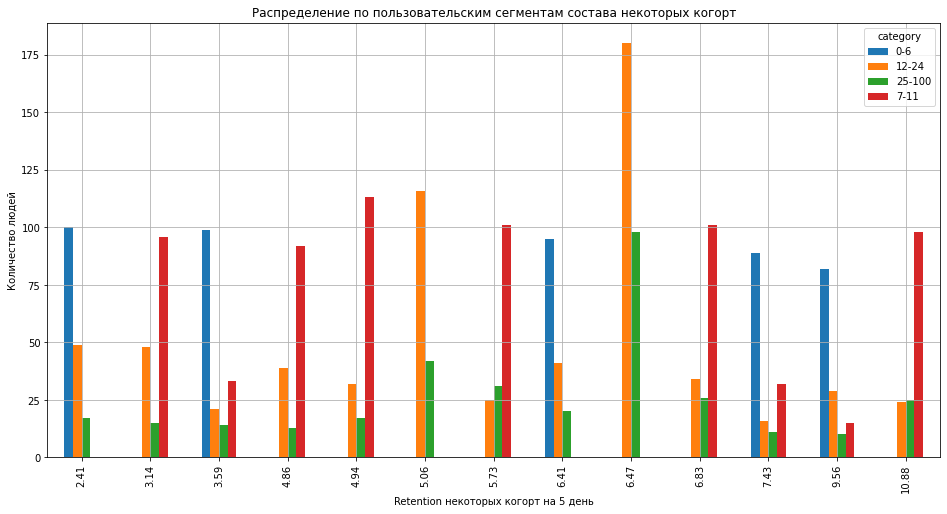

In [65]:
#финальная таблица, присоединяю всё, что можно
final_table=mobile_dataset.merge(first_visit,how='left',left_on='user_id',right_on='user_id')
final_table=final_table.merge(new_table,how='right',left_on='first_visit',right_on='first_visit')
final_table=final_table.merge(people_percent_category,how='left',left_on='user_id',right_on='user_id')
final_table=final_table.pivot_table(columns='category',index='Retention_5_day',values='user_id',aggfunc='nunique')
final_table=final_table.fillna({'0-7':0,'8-12':0})
final_table.plot(title=('Распределение по пользовательским сегментам состава некоторых когорт'),xlabel='Retention некоторых когорт на 5 день',ylabel='Количество людей',kind='bar',linewidth=10,grid=True,figsize=(16,8));

- Как сделать из этого графика нормированную столбчатую диаграмму? Чтобы столбики все были одной высоты и можно было смотреть на отношение частей внутри столбиков?

Честно, я в недоумении, почему у когорт с высоким количеством часто заходящих пользователей (13-25 и 26+ группы) rr не выше, чем у когорт с 50+% состава из людей с частотой захода до 7%. 

### Cоздаю хитмап Retention Rate по когортам

Как я буду его считать: я возьму все когорты, которые прожили 10+ дней, и их 

In [66]:
retention_cohort=mobile_dataset.merge(people_percent_category,how='left',left_on='user_id',right_on='user_id').drop_duplicates(subset=
                   ['event_time','user_id']).drop(columns=['day','event_name','percent','days'])

In [67]:
retention_cohort=retention_cohort.merge(first_visit,how='left',left_on='user_id',right_on='user_id')

In [68]:
retention_cohort=retention_cohort[retention_cohort['first_visit']<='2019-10-25'].drop(columns=['user_id','active_days','days'])

In [69]:
retention_cohort['retention_day']=retention_cohort['event_time']-retention_cohort['first_visit']

In [70]:
retention_cohort=retention_cohort[retention_cohort['retention_day']<timedelta(days=11)]

In [71]:
retention_cohort['retention_day']=retention_cohort['retention_day'].astype('str')

In [72]:
retention_cohort=retention_cohort.pivot_table(index='category',columns='retention_day',values='first_visit',aggfunc='count').fillna(0)

In [73]:
retention_cohort=retention_cohort.div(retention_cohort['0 days'],axis=0)

In [74]:
retention_cohort=round(retention_cohort.replace({1:0}),2)

In [75]:
retention_cohort=retention_cohort.drop(columns=['10 days'])

In [76]:
retention_cohort

retention_day,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days
category,,,,,,,,,,
0-6,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12-24,0.0,0.33,0.20,0.18,0.12,0.12,0.09,0.10,0.08,0.05
25-100,0.0,0.50,0.45,0.43,0.32,0.32,0.34,0.41,0.31,0.28
7-11,0.0,0.09,0.03,0.03,0.02,0.01,0.01,0.01,0.02,0.01


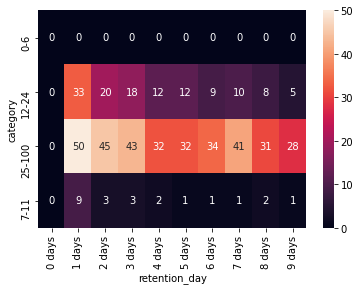

In [77]:
sns.heatmap(data=retention_cohort*100,annot=True);

Как видим, в любой когорте людей с 12+ процентом посещений - минимальное количество. 

### Даю ответ на вопрос, какая группа лучше по конверсии

In [78]:
# перебираем каждую группу. На каждой итерации ДЕЛИМ количество подходяших записей из логов (2 условия:
# человек принадлежит иттерируемой категории и действие - просмотр контактов НА общее число людей в категории
for i in people_percent_category['category'].unique():
    print(i)
    print(round(mobile_dataset[(mobile_dataset['user_id'].isin(people_percent_category[people_percent_category['category']==i]['user_id']))&
                               (mobile_dataset['event_name']=='contacts_show')]['user_id'].nunique()/
                len(people_percent_category[people_percent_category['category']==i])*100,2))
    print('____')

12-24
23.5
____
25-100
32.79
____
0-6
16.07
____
7-11
19.41
____


Как видно, с повышением доли активных дней у пользователя, его конверсия растёт: по мере роста доли активных дней сначала она 16.03, потом 21.35, потом 23.71, и в конце 32.43

Результаты сегментации. Пользователи были сегментированы по частоте захода в приложение по ряду причин, описанных в начале раздела. 

Смотря на Retention Rate по сегментам нельзя сделать очевидных выводов, какой сегмент лучше из-за того, что напрямую связь не оценить: rr вводится для когорты, а когорта содержит в себе несколько сегментов. Таким образом можно только прикинуть у какого сегмента Retention Rate выше, опираясь на изменение доли сегмента от когорты к когорте при повышении RR. Но сегментация не выявила явных закономерностей.

Смотря на конверсию в разбивке по сегментам, можно сделать вывод, что пользователи, входящие в сегменты с повышенным % возвращаемости показывают себя лучше в конверсии, чем сегменты с низким % частоты захода в приложение

## Проверка гипотез

### На предмет различия конверсии в просмотры контактов между пользователями, скачавшими приложение из google и из yandex

Пускай H_0: конверсия в целевое действие (просмотр контаков) не отличается у пользователей, пришедших в приложение через yandex и google
Тогда H_1: конверсия в целевое действие (просмотр контаков) отличается у пользователей, пришедших в приложение через yandex и google

In [79]:
#Приделываем к mobile_dataset информацию об источнике захода каждого пользователя
table_13=mobile_dataset.merge(mobile_sources,how='left',left_on='user_id',right_on='user_id')

In [80]:
def test_new(alpha):
    
    # число пользователей в группе 1 и группе 2:
    users = np.array([table_13[table_13['source']=='yandex']['user_id'].nunique(), 
                        table_13[table_13['source']=='google']['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2  
    success = np.array([table_13[(table_13['source']=='yandex')&(table_13['event_name']=='contacts_show')]['user_id'].nunique(), 
                        table_13[(table_13['source']=='google')&(table_13['event_name']=='contacts_show')]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/users[0]
    p2 = success[1]/users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (users[0] + users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/users[0] + 1/users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('H_0 не похожа на правду, отвергаем её и принимаем Н_1')
    else:
        print('Н_0 имеет небольшие шансы быть не верной. Принимаем её. Группы пользователей скорее не различаются ')

In [81]:
test_new(0.05)

p-значение:  0.8244316027993777
Н_0 имеет небольшие шансы быть не верной. Принимаем её. Группы пользователей скорее не различаются 


p-value получился даже не близко к критическому уровню. H_0 с большой долей вероятности верна и группы на самом деле всё-таки не отличаются

### На предмет частоты захода в приложение в выходные и будние дни

ВАЖНО. В ходе рассуждений понятие "частота захода в приложение в будние и выходные дни" я буду обзывать "конверсией" (захода в приложение в выходные или будние дни)

Пускай H_0: частота захода в приложение в будние и выходные дни совпадает, тогда 

H_1: частота захода в приложение в будние и выходные дни не совпадает

Сначала создам таблицу дат, фигурирующих в mobile_dataset + соответствующих дней недели 

In [82]:
#таблица для сопоставления даты и дня недели 
date_day=mobile_dataset.drop_duplicates(subset=['event_time'])[['event_time']].rename(columns={'event_time':'date'}).reset_index()
date_day['day']=date_day['date'].dt.weekday

In [83]:
# Теперь функции, возвращающие для каждого пользователя количество будних и выходных дней, которые прошли с момента его первого захода
def all_weekday(a):
    return len(date_day[(date_day['date']>=a[1])&(date_day['day'].isin([0,1,2,3,4]))])
def all_weekend(a):
    return len(date_day[(date_day['date']>=a[1])&(date_day['day'].isin([5,6]))])

In [84]:
#применяем функции 
table_13=first_visit
table_13['all_weekday']=table_13.apply(all_weekday,axis=1)
table_13['all_weekend']=table_13.apply(all_weekend,axis=1)

In [85]:
#cоздаю столбик с днём в исходном датасете, он нужен будет в следующей ячейке
mobile_dataset['day']=mobile_dataset['event_time'].dt.weekday

In [86]:
#делаем слияние: каждому пользователю из нашей таблицы добавляем количество его активных будних дней
table_13=table_13.merge(mobile_dataset[mobile_dataset['day'].isin([0,1,2,3,4])].groupby('user_id',as_index=False)
                        .agg({'event_time':'nunique'}),how='left',left_on='user_id',right_on='user_id')

In [87]:
table_13=table_13.rename(columns={'event_time':'active_weekday'})

In [88]:
#делаем ещё одно слияние с mobile_dataset для выявления количества активных выходных дней для каждого пользователя 
table_13=table_13.merge(mobile_dataset[mobile_dataset['day'].isin([5,6])].groupby('user_id',as_index=False)
                        .agg({'event_time':'nunique'}),how='left',left_on='user_id',right_on='user_id')

In [89]:
table_13=table_13.rename(columns={'event_time':'active_weekend'})

In [90]:
#т.к. логи мы присоединяли левым джоином, то на месте количества активных дней могут быть пропуски, которые нужно заполнить нулями
table_13=table_13.fillna({'active_weekday':0,'active_weekend':0})
table_13=table_13.astype({'active_weekday':'int','active_weekend':'int'})

In [91]:
#расчитываем конверсии и округляем до целого, чтобы ttest смог сработать
table_13['conversion_weekday']=(table_13['active_weekday']*100/table_13['all_weekday']).apply(np.ceil)
table_13['conversion_weekend']=(table_13['active_weekend']*100/table_13['all_weekend']).apply(np.ceil)

In [92]:
# применяем t тест, скармиливая ему массивы пользовательских частот посещений приложения по выходным и по будням 

# И вот какой прикол. При передаче массивов в первозданном виде p-value получается мизерный из-за особенностей расчёта конверсий:
# в массиве выходных популярны конверсии 0, 25, 34, 50, 100, получаемые при делении на небольшое количество выходных, пережитых
# человеком. Настоящую ценность имеют люди, давно находящиеся в приложении, и сформировавшие свою конверсию отличной от заезженных
# 0 25 34 50 100. Но таких людей всего порядка 18% (ячейкой ниже есть доли конверсий в массиве). Придётся их отбросить для 
# корректности расчётов. При этом отбросим и схожие частоты в массиве будних дней
results = st.ttest_ind(table_13[(~table_13['conversion_weekend'].isin([0,25,34,50,100]))&(~table_13['conversion_weekday'].isin([0,25,34,50,100]))]['conversion_weekday'],
                       table_13[(~table_13['conversion_weekend'].isin([0,25,34,50,100]))&(~table_13['conversion_weekday'].isin([0,25,34,50,100]))]['conversion_weekend'],
                       equal_var=True)
alpha = 0.05 
print(results.pvalue) 
if results.pvalue>alpha:
    print('Не получилось отвергнуть нулевую гипотезу, принимаем её')
else:
    print('Отвергаем нулевую гипотезу')

0.0046256900030992
Отвергаем нулевую гипотезу


In [93]:
table_13['conversion_weekend'].value_counts(normalize=True)

0.0      0.636152
25.0     0.055672
50.0     0.051712
17.0     0.049849
34.0     0.044491
13.0     0.041230
100.0    0.039832
20.0     0.030282
15.0     0.027952
67.0     0.005125
29.0     0.004892
38.0     0.003494
40.0     0.002096
75.0     0.001863
63.0     0.001165
60.0     0.000932
43.0     0.000699
84.0     0.000699
88.0     0.000699
58.0     0.000699
72.0     0.000233
80.0     0.000233
Name: conversion_weekend, dtype: float64

In [94]:
table_13['conversion_weekday'].value_counts(normalize=True)

0.0      0.146762
6.0      0.081753
10.0     0.076582
20.0     0.065255
7.0      0.061807
8.0      0.056144
15.0     0.043585
12.0     0.041862
50.0     0.041123
17.0     0.040138
25.0     0.037922
100.0    0.035952
13.0     0.035459
34.0     0.035459
9.0      0.027333
5.0      0.026594
14.0     0.014528
40.0     0.014528
23.0     0.010342
16.0     0.010096
19.0     0.008372
67.0     0.008372
29.0     0.007141
11.0     0.007141
30.0     0.006156
22.0     0.005171
60.0     0.004679
28.0     0.004186
27.0     0.004186
24.0     0.004186
38.0     0.003694
43.0     0.002955
18.0     0.002955
75.0     0.002709
80.0     0.002462
37.0     0.001970
32.0     0.001724
36.0     0.001477
31.0     0.001477
39.0     0.001231
58.0     0.001231
47.0     0.000985
42.0     0.000985
69.0     0.000985
63.0     0.000985
45.0     0.000985
65.0     0.000739
72.0     0.000739
84.0     0.000739
70.0     0.000739
73.0     0.000492
46.0     0.000492
54.0     0.000492
35.0     0.000492
48.0     0.000492
74.0     0

p-value перешёл на тёмную сторону и мы отвергаем H_0: по представленным данным очень маловероятно, что она является правдой. При чём если уменьшить список конверсий, которые мы не будем учитывать, то p-value будет ещё ниже критического уровня значимости. Но если выкинуть из массивов конверсии 67%, 10%, 40%, 17% и другие, то тут уже мы заденем тех немногочисленных пользователей, которые имеют адекватный уровень конверсии в следствие долгого пребывания в приложении => устаканивании конверсии. В общем для т-теста я посчитал пригодными пользователей, относительно давно находящихся в приложении.

P.S. Сейчас попробовал иной подход: не отсекать конверсии, подходящие под людей, портящих статистику своим малым общим числом выходных и будней, а отсекать самих людей, которые могут статистику испортить. Эту настройку сделал вот так: table_13=first_visit[first_visit['first_visit']<'2019-10-24'] + не исключал людей из-за конверсии. Потому что люди и так имеют достаточно дней и их конверсия по представленным данным не сильно отличается от истинной конверсии. Так вот, p-value оказался ещё ниже.

Итого: частота захода в приложение в выходные и будние дни - отличается. Оба подхода показали низкий p-value

Финальный вывод + рекомендации.

В ходе исследования я изучил специфику пользователей приложения "Не нужные вещи": 
- на основе пользовательских формирований (когорты, сегменты) на предмет Retention Rate, конверсии
- на основе индивидуальных историй взаимодействия с приложением (частота захода в приложение, время в приложении)

Выполняя поставленные задачи, 4/4 целей были достигнуты: 
- Какой пользовательский сегмент лучше других по Retention Rate
   - Выяснил. Оценки RR по сегментам - приближённые и их точности оказалось не достаточно, чтобы выявить отличия. Но определив сегменты как категории и построив тепловую карту RR - можно сделать выводы, что чем больше частота захода в приложение, тем больше RR 
- узнать, какой пользовательский сегмент лучше других по конверсии
   - Конверсия лучше у тех пользователей, кто состоит в сегментах с бОльшей частотой захода в приложение
- узнать, различается ли конверсия в целевое действие у пользователей, пришедших из yandex и google
   - Конверсия в целевое действие скорее не различается у двух групп пользователей
- узнать, различается ли частота захода в приложение в будние и выходные дни
   - Частота захода в приложение в будние и выходные дни с очень большой вероятностью различается. Т.е. люди имеют более высокий шанс зайти в выходной день, нежели в будний
   
Рекомендации:
- Опираясь на факт, что 13% пользовательских сессий заканчиваются после первого действия, можно предположить, что это какой-нибудь баг, из-за которого пользователей выкидывает из приложения после первого действия, либо другие действия становятся не возможными
- Опираясь на следующие полученные цифры: 80% новых пользователей отваливаются на второй день, а через неделю отваливаются ещё 15%, можно сказать, что нужно улучшать/внедрять/разрабатывать функции приложения, которые предназначены для удержания людей
- Опираясь на не статистически значимую разницу между пользователями, пришедшими из yandex и google, можно сказать, что можно смело покупать больше рекламы у более дешёвого сервиса, дабы выручить деньги
- Опираясь на практически факт, что люди чаще заходят в выходные, нежели в будни, можно сказать, что спецпредложения, акции в приложении нужно проводить по выходным, а возможные обновления приложение - в разгруженные выходные дни
- Опираясь на фактическую вредность местами до 83% логов при анализе пользовательских сессий, можно сказать, что не стоит слепо доверять подсчитанным метрикам на основе логов в случае не фильтрации последних: метрики (конверсия, rr, частота) могут искажаться

<div class="alert alert-block alert-success">✔️
    

__Комментарий от тимлида__

Итоговый вывод завершает твое исследование. Представлены основные результаты полученные в ходе анализа, но самое главное - даны рекомендации по  развитию приложения. 

</div>

Итоги по исследованию сессий пользователей:
- средняя сессия составляет 01:23:02
- 77% сессий укладывается в рамки одного часа
- аномально большие сессии есть, но их критически мало
- нулевых сессий порядка 13% от общего числа ((1014/6050)*17%)